In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os
import warnings
from configs.enums import Column
from machine_learning.utils import split_data, scale_dataset
from machine_learning.neural_networks.utils import plot_history, get_tensorflow_version
from machine_learning.neural_networks.fnn import train_fnn_model
from configs.data import MACHINE_LEARNING_DATASET_PATH
import pandas as pd
from tensorflow.keras.models import load_model
warnings.simplefilter(action='ignore', category=FutureWarning)

2023-12-05 18:46:31.813204: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 18:46:32.094460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 18:46:33.143054: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 18:46:33.143229: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 18:46:33.145307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## 1. Loading the dataset

In [2]:
per_feature_path = "per-feature"

df = pd.read_excel(MACHINE_LEARNING_DATASET_PATH)
x_feature = Column.DUR
y_feature = Column.IPRIV

df_2_features = df[[x_feature, y_feature, Column.COUNTRY_RISK]]
_, _, test = split_data(df_2_features)
scaled_test, x_test, test_labels = scale_dataset(test, oversample=False)

## 2. FNN

In [3]:
def subplot_scatter(ax, data: pd.DataFrame, risk_col: Column | str, title: str) -> None:
    low = data[data[risk_col] == 0]
    med = data[data[risk_col] == 1]
    hig = data[data[risk_col] == 2]
    
    l = ax.scatter(low[x_feature], low[y_feature], color="green")
    m = ax.scatter(med[x_feature], med[y_feature], color="yellow")
    h = ax.scatter(hig[x_feature], hig[y_feature], color="red")
    
    ax.legend([l, m, h], ("low", "medium", "high"), loc="best")
    ax.grid(True)
    ax.set_xlabel(x_feature.get_description())
    ax.set_ylabel(y_feature.get_description())
    ax.title.set_text(title)

In [4]:
def tune_fnn_model(df, layers, units, dropout_rates, learning_rates, patience=[10, 20]):
    import time
    from datetime import timedelta
    
    least_val_lost_file_name = f"tuning_least_val_loss.fnn.keras"
    
    to_hh_mm_ss = lambda seconds: str(timedelta(seconds=seconds)).rsplit(".")[0]
    
    least_val_loss = float('inf')
    least_val_loss_params = []
    eta = None
    
    epochs = 200
    time_past = 0
    
    i = 1 
    max = len(layers) * len(units) * len(dropout_rates) * len(learning_rates) * len(patience)
    
    print("[prev: N/A] [eta: TBD]")
    
    for l in layers:
        for u in units:
            for dr in dropout_rates:
                for lr in learning_rates: 
                    for pt in patience:
                        start_time = time.time()

                        print(f"[{i}/{max}] Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt};")
                        
                        # TODO: add batch_size param to tune
                        model, history, num_classes = train_fnn_model(
                            df, 
                            epochs=epochs, 
                            patience=pt, 
                            layers=l, 
                            units=u,
                            dropout_rate=dr,
                            learning_rate=lr,
                            verbose=0,
                            disable_save=True,
                            disable_plot_history=True,
                            disable_print_report=True)
                        
                        val_loss, val_acc = model.evaluate(x_test, test_labels)
                        print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                        if val_loss < least_val_loss:
                            model.save(os.path.join(os.environ["OUTPUT_PATH"], per_feature_path, least_val_lost_file_name))
                            least_val_loss = val_loss
                            least_val_loss_params = [l, u, dr, lr, pt]
                            
                        duration = time.time() - start_time
                        time_past += duration
                        avg_duration = time_past / i
                        eta = time_past + avg_duration * (max - i)
                        
                        print(f"\n[eta: {to_hh_mm_ss(time_past)}/{to_hh_mm_ss(eta)}] [prev: {to_hh_mm_ss(duration)}] [avg: {to_hh_mm_ss(avg_duration)}]")
                            
                        i += 1
    
    l, u, dr, lr, pt = least_val_loss_params
    print("\nLeast validation loss:")              
    print(f"\tParams:\t {{Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt};}}")
    print("\tLoss:\t", least_val_loss)
    
    best_model_file_name = f"tf-{get_tensorflow_version()}_Adam_{l}_{u}_{dr}_{lr}_{epochs}_{pt}.{x_feature}-{y_feature}.fnn.keras"
    os.rename(
        os.path.join(os.environ["OUTPUT_PATH"], per_feature_path, least_val_lost_file_name), 
        os.path.join(os.environ["OUTPUT_PATH"], per_feature_path, best_model_file_name))
    print(f"\nModel has been saved as '{best_model_file_name}'")
    
    plot_history(history, num_classes)
    
    y_pred = model.predict(x_test).argmax(axis=1)
    print(classification_report(test_labels, y_pred))
    
    return model, history, num_classes

### 2.1 Tuning

In [ ]:
model, history, num_classes = tune_fnn_model(
        df=df_2_features,
        layers=[2, 3, 4, 5, 6], # 1, 2, 3
        units=[64, 96, 128], # 8, 16, 32, 64
        dropout_rates=[0.2],
        learning_rates=[0.0015, 0.00175], # 0.001, 0.0015, 0.002  
        patience=[10]
    )

### 2.2 Manual tuning

In [ ]:
# train_fnn_model(
#                 df_2_features, 
#                 epochs=100, 
#                 patience=20, 
#                 layers=3, 
#                 units=128,
#                 dropout_rate=0.2,
#                 learning_rate=0.0015,
#                 verbose=2)

### 2.3 Plotting

47/47 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.97      0.74       299
           1       0.87      0.81      0.84      1078
           2       0.00      0.00      0.00       119

    accuracy                           0.78      1496
   macro avg       0.49      0.59      0.53      1496
weighted avg       0.75      0.78      0.75      1496


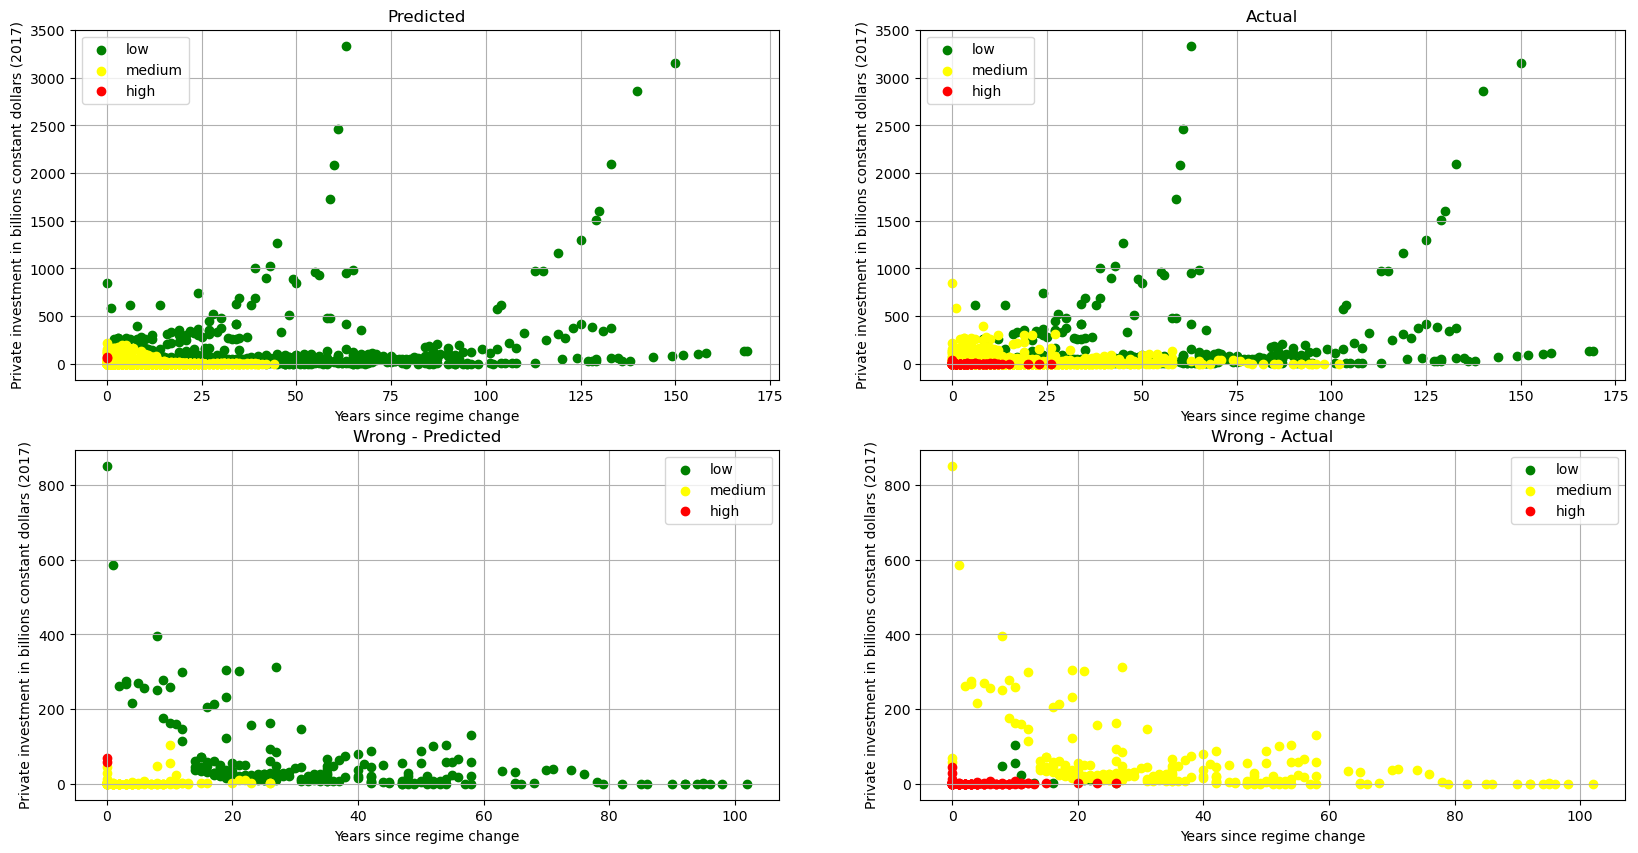

In [5]:
# model_file = "tf-2.14.0_Adam_6_64_0.2_0.0015_200_10.durable-ipriv_rppp.fnn.keras" 
# model = load_model(os.path.join(os.environ["OUTPUT_PATH"], per_feature_path, model_file))

y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(test_labels, y_pred))

result = test 
result["predicted_country_risk"] = y_pred

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))
subplot_scatter(ax1, result, "predicted_country_risk", "Predicted")
subplot_scatter(ax2, result, "country_risk", "Actual")

wrong = result[y_pred != test_labels]
subplot_scatter(ax3, wrong, "predicted_country_risk", "Wrong - Predicted")
subplot_scatter(ax4, wrong, "country_risk", "Wrong - Actual")

plt.show()